In [89]:
!pip install wget

In [90]:
import gensim
import numpy as np
import pandas as pd
from sklearn import metrics
from gensim.corpora import Dictionary
import wget
import urllib.request
import pickle
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [ ]:
# load dictionary

url = 'https://raw.githubusercontent.com/namvnvx/DS107_Project/main/dictionary.gensim'
wget.download(url, 'dictionary.gensim')
dictionary = Dictionary.load('dictionary.gensim')

# load 3 corpus từng sentiment

url1_1 = 'https://raw.githubusercontent.com/namvnvx/DS107_Project/main/Corpus/positive_corpus.pkl'
with urllib.request.urlopen(url1_1) as e:
    bow_pos = pickle.load(e)

url1_2 = 'https://raw.githubusercontent.com/namvnvx/DS107_Project/main/Corpus/neutral_corpus.pkl'
with urllib.request.urlopen(url1_2) as f:
    bow_neu = pickle.load(f)

url1_3 = 'https://raw.githubusercontent.com/namvnvx/DS107_Project/main/Corpus/negative_corpus.pkl'
with urllib.request.urlopen(url1_3) as g:
    bow_neg = pickle.load(g)

# load test_data

test_data = pd.read_csv('https://raw.githubusercontent.com/namvnvx/DS107_Project/main/Demo_data/test_data.csv')
X_test = test_data['tweet'].values
y_test = test_data['class'].values

In [91]:
lda_neu =  gensim.models.LdaMulticore(bow_neu, num_topics = 20, id2word = dictionary, passes = 10, workers = 3)
lda_pos =  gensim.models.LdaMulticore(bow_pos, num_topics = 20, id2word = dictionary, passes = 10, workers = 3)
lda_neg =  gensim.models.LdaMulticore(bow_neg, num_topics = 20, id2word = dictionary, passes = 10, workers = 3)

In [92]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [93]:

stemmer = SnowballStemmer("english")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def pre_process(data):
    final = []
    for text in data:
      result=[]
      for token in gensim.utils.simple_preprocess(text) :
          if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
              result.append(lemmatize_stemming(token))
      final.append(result)

    return final

In [94]:
class_0 = []
class_1 = []
class_2 = []

X_test_processing = pre_process(X_test)

for text in X_test_processing:
  bow_vector =  dictionary.doc2bow(text)
    #Train neutral topic
  neu_topic = lda_neu.get_document_topics(bow_vector)
  neu_score = sorted(neu_topic, key=lambda x: -x[1])[0][1]
  class_1.append(neu_score)

    #Train positive topic
  pos_topic = lda_pos.get_document_topics(bow_vector)
  pos_score = sorted(pos_topic, key=lambda x: -x[1])[0][1]
  class_2.append(pos_score)

    #Train negative topic
  neg_topic = lda_neg.get_document_topics(bow_vector)
  neg_score = sorted(neg_topic, key=lambda x: -x[1])[0][1]
  class_0.append(neg_score)

  scores_array = np.array([neu_score, pos_score, neg_score])
  max_score = np.max(scores_array)

In [95]:
max(class_0[3], class_1[3], class_2[3])

0.5124579

In [96]:
class_pred = []
# 1 phương thức đánh giá nào đó
for neg, neu, pos in zip(class_0, class_1, class_2):
  m = max(neg, neu, pos)
  if m == neg:
    class_pred.append(0)
    continue
  elif m == neu:
    class_pred.append(1)
    continue
  elif m == pos:
    class_pred.append(2)


In [97]:
accuracy = metrics.accuracy_score(class_pred, y_test)
accuracy

0.3876377074327151

In [98]:
from sklearn.metrics import f1_score
f1 = f1_score(class_pred, y_test,average=None)
print("F1 Score:", f1)

F1 Score: [0.3752382  0.38743244 0.39970839]


In [99]:
for idx, topic in lda_neu.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")


Topic: 0 
Words: 0.026*"today" + 0.019*"post" + 0.015*"western" + 0.014*"think" + 0.014*"case" + 0.013*"read" + 0.013*"futur" + 0.012*"plea" + 0.012*"patient" + 0.010*"visit"


Topic: 1 
Words: 0.022*"donald" + 0.020*"happen" + 0.019*"wait" + 0.019*"month" + 0.018*"learn" + 0.015*"know" + 0.015*"trump" + 0.014*"store" + 0.012*"coupl" + 0.012*"test"


Topic: 2 
Words: 0.028*"test" + 0.023*"includ" + 0.014*"measur" + 0.013*"open" + 0.011*"servic" + 0.010*"recent" + 0.010*"week" + 0.010*"church" + 0.010*"webinar" + 0.009*"hospit"


Topic: 3 
Words: 0.020*"look" + 0.016*"famili" + 0.014*"trace" + 0.013*"corona" + 0.012*"america" + 0.011*"tell" + 0.011*"initi" + 0.010*"week" + 0.010*"contact" + 0.010*"market"


Topic: 4 
Words: 0.025*"peopl" + 0.021*"state" + 0.018*"trump" + 0.017*"lockdown" + 0.016*"pandem" + 0.014*"plan" + 0.014*"leader" + 0.012*"member" + 0.011*"presid" + 0.010*"start"


Topic: 5 
Words: 0.021*"time" + 0.019*"case" + 0.018*"leav" + 0.018*"right" + 0.016*"past" + 0.015*"l

In [100]:
def count_word_in_topic(lda_neu):
  word_counts = set()
  for i in range(0,20,1):
    for word, weight in lda_neu.show_topic(i):
      word_counts.add(word)

  neu_topic_word_counts = {}
  for word in word_counts:
    count = 0
    for i in range(0,20,1):
      for word_lda, weight in lda_neu.show_topic(i):
        if word == word_lda:
          count += 1
    neu_topic_word_counts[word] = count
  return neu_topic_word_counts

#==============================================
neu_wordCount = count_word_in_topic(lda_neu)
neg_wordCount = count_word_in_topic(lda_neg)
pos_wordCount = count_word_in_topic(lda_pos)


def fix_count(pos_wordCount):
  count_fix = {}
  for i,j in pos_wordCount.items():
    if j > 1:
      count_fix[i] = j
  return count_fix

#=============================================
neu_fix = fix_count(neu_wordCount)
neg_fix = fix_count(neg_wordCount)
pos_fix = fix_count(pos_wordCount)



In [113]:
sent_list = [neu_fix, neg_fix, pos_fix]

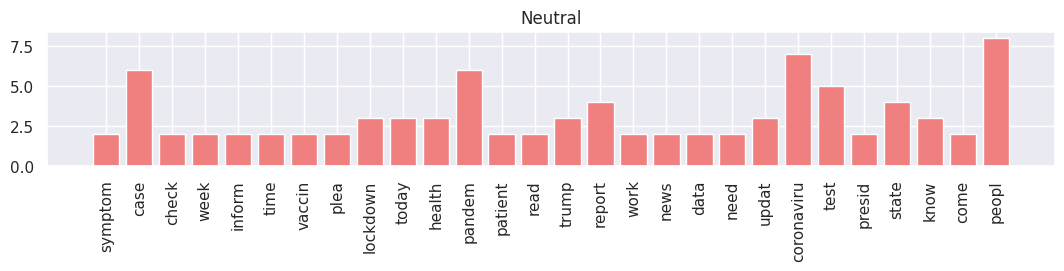

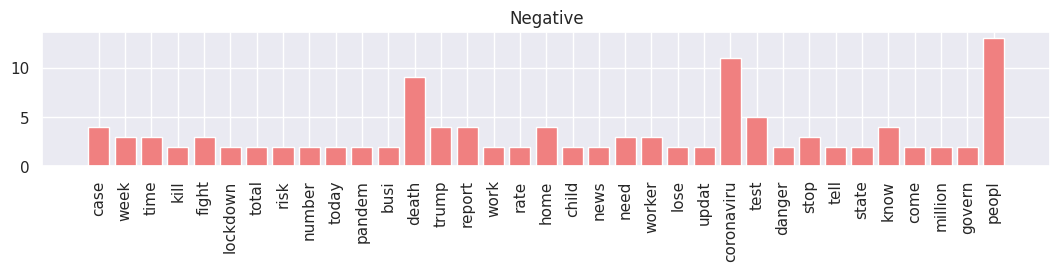

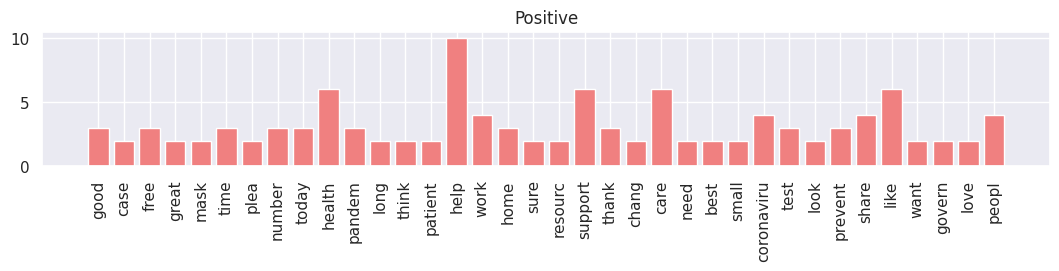

In [116]:
import matplotlib.pyplot as plt

import seaborn as sns
name_list = ['Neutral', 'Negative', 'Positive']

for name, sentiment in zip(name_list, sent_list):
  x = sentiment.keys()
  y = sentiment.values()

  plt.figure(figsize=(13,1.75))
  plt.bar(x, y, color='lightcoral')
  plt.xticks(rotation=90)
  plt.title(name)
  plt.show()
